In [5]:
import pandas as pd
import matplotlib 
from utils import *
from training import *

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat_peak > -100')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat_peak > -100')

data = pd.concat([bgu, bdu]).sort_values('reportts').drop(columns=['file_path', 'dep', 'arr'])


In [6]:
def correct(data, alpha_2 = 0.869):
  datak = data
  alpha = 0.5

  theta = (data['t2'] + 273.16) / (288.16)
  theta_peak = (data['t2_peak'] + 273.16) / (288.16)
  delta = data['p2e'] / 29.92

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n1k'] = data['n1'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.16) / (theta ** alpha_2)
  datak['egtk_2'] = (data['egt'] + 273.16) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta ** 0.59))

  datak['egt_peak_k'] = (data['egt_peak'] + 273.16) / (theta_peak ** alpha_2)
  datak['n1a_peak_k'] = data['n1a_peak'] / (theta_peak ** alpha)
  datak['n1_peak_k'] = data['n1_peak'] / (theta_peak ** alpha)
  datak['n2a_peak_k'] = data['n2a_peak'] / (theta_peak ** alpha)

  return datak

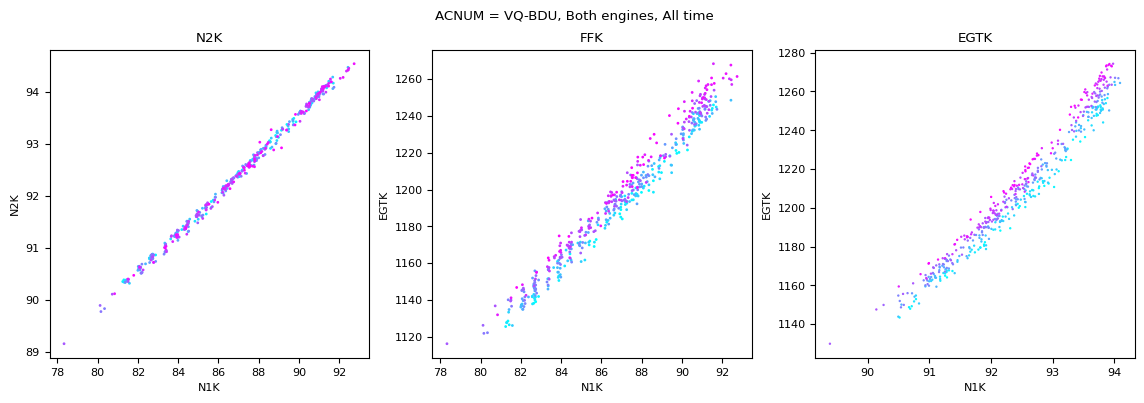

In [24]:

def plot_baselines(data, title):
  plt.rcParams.update({'font.size': 8})
  fig, axs = plt.subplots(1, 3)
  fig.set_size_inches(14, 4)
  fig.suptitle(title)
  
  cm = matplotlib.colormaps['cool']

  axs[0].scatter(data['n1ak'], data['n2ak'], s=1, c=data['reportts'], cmap=cm)
  axs[0].set(xlabel='N1K', ylabel='N2K', title="N2K")

  axs[1].scatter(data['n1ak'], data['egtk'], s=1, c=data['reportts'], cmap=cm)
  axs[1].set(xlabel='N1K', ylabel='EGTK', title="FFK")

  axs[2].scatter(data['n2a_peak_k'], data['egt_peak_k'], s=0.5, c=data['reportts'], cmap=cm)
  axs[2].set(xlabel='N1K', ylabel='EGTK', title="EGTK")

  plt.show()

data = correct(bdu, alpha_2=0.942)

plot_baselines(data.query('pos == 2')[:500], title='ACNUM = VQ-BDU, Both engines, All time')

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

best_r = -1000
best_a = 1000
for a in range(7000, 9999):
  data = correct(bdu, alpha_2=(a / 11_000))
  
  sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')][:100]

  model = make_pipeline(PolynomialFeatures(2), LinearRegression())
  model.fit(sub[['n1a_peak_k']], sub['egt_peak_k'])

  pred = model.predict(sub[['n1a_peak_k']])

  r2 = r2_score(sub['egt_peak_k'],  pred)

  if r2 > best_r:
    best_r = r2
    best_a = a / 10_000 

best_r, best_a

(0.9902252989840944, 0.9842)

alpha2(n1, ...) 

bleed + nai + wai ... 

corner point approx 35 deg
